In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
import xgboost as xgb
from sklearn import tree
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.base import clone
from utils import *

In [2]:
# reading in the cleaned data and the data dictionary
df = pd.read_pickle('../data/highered_cleaned.pkl')
data_dict = pd.read_pickle('../data/data_dictionary.pkl')

## Understanding The Data

In [3]:
df.shape

(119153, 23)

In [4]:
df.columns

Index(['YEAR', 'NMRMEMG', 'HRSWKGR', 'WKSWKGR', 'OCEDRLP', 'EMSEC', 'EMSIZE',
       'GOVSUP', 'ACTCAP', 'ACTDED', 'ACTMGT', 'ACTRD', 'ACTRDT', 'ACTRES',
       'ACTTCH', 'WADEV', 'WADSN', 'WAEMRL', 'WAMGMT', 'WAOT', 'WAPROD',
       'SALARY', 'JOBSATIS'],
      dtype='object')

We want to see what the columns in the dataframe mean, and what values they have. We will use our data dictionary to do this.

In [5]:
for col in df.columns:
    print(f'{col}: {data_dict[col]["var_desc_short"]} ({data_dict[col]["data_values"]})')

YEAR: Survey year ({})
NMRMEMG: Field of study of major for most recent degree (major group) ({1: 'Computer and math sciences', 2: 'Life and related sciences', 3: 'Physical and related sciences', 4: 'Social and related sciences', 5: 'Engineering', 6: 'Science and engineering-related fields', 7: 'Non-science and engineering fields', 9: 'Other categories', 99: 'Missing'})
HRSWKGR: Principal job: hours per week typically worked (group) ({1: '20 or less', 2: '21 - 35', 3: '36 - 40', 4: 'Greater than 40', 98: 'Logical Skip'})
WKSWKGR: Principal job weeks salary based on year (group) ({1: '1-10 weeks', 2: '11-20 weeks', 3: '21-39 weeks', 4: '40-52 weeks', 98: 'Logical Skip'})
OCEDRLP: Principal job related to highest degree ({1: 'Closely related', 2: 'Somewhat related', 3: 'Not related', 98: 'Logical Skip'})
EMSEC: Employer sector ({1: '2 year college or other school system', 2: '4 year college or medical institution', 3: 'Government', 4: 'Business or industry', 5: 'Non-US government', 98: '

## Correlations of Features

In [6]:
corr = df.corr()
corr.style.background_gradient('coolwarm')

,YEAR,NMRMEMG,HRSWKGR,WKSWKGR,OCEDRLP,EMSEC,EMSIZE,GOVSUP,ACTCAP,ACTDED,ACTMGT,ACTRD,ACTRDT,ACTRES,ACTTCH,WADEV,WADSN,WAEMRL,WAMGMT,WAOT,WAPROD,SALARY,JOBSATIS
YEAR,1.000000,0.006998,-0.032079,0.013484,-0.007923,0.010623,0.006075,-0.002683,-0.002064,-0.001578,-0.007086,-0.002057,0.003913,-0.000137,-0.017297,0.013419,0.032258,-0.029849,0.008687,0.051696,0.016509,0.126447,0.024054
NMRMEMG,0.006998,1.000000,-0.054799,-0.009575,-0.043225,0.064217,-0.074581,-0.090008,-0.044564,0.080433,0.007252,-0.060786,-0.054447,-0.108374,0.015275,0.077097,0.083639,0.018050,-0.007767,0.013196,-0.014731,0.025518,-0.011618
HRSWKGR,-0.032079,-0.054799,1.000000,0.113336,-0.060319,-0.138168,0.277005,0.128729,-0.028350,0.002280,0.081113,0.165593,0.126802,0.153226,0.040474,0.063975,0.076218,0.147187,0.267545,0.016312,0.052312,0.336737,0.000015
WKSWKGR,0.013484,-0.009575,0.113336,1.000000,0.121455,0.263378,-0.072944,-0.001400,0.077736,0.127059,0.129370,-0.000732,-0.130680,-0.059375,-0.333016,0.128221,0.099651,0.047527,0.069550,-0.054456,0.072017,0.205446,0.020646
OCEDRLP,-0.007923,-0.043225,-0.060319,0.121455,1.000000,0.313593,-0.145334,-0.111980,0.156175,0.104303,0.168872,-0.181404,-0.285704,-0.255004,-0.268137,0.058244,0.071403,0.033394,-0.002082,-0.003740,0.064450,0.059392,0.114735
EMSEC,0.010623,0.064217,-0.138168,0.263378,0.313593,1.000000,-0.496017,-0.235852,0.167074,0.376113,0.190010,-0.087856,-0.330410,-0.279425,-0.591467,0.336011,0.250593,-0.005882,-0.024502,-0.081911,0.123170,0.263368,0.016759
EMSIZE,0.006075,-0.074581,0.277005,-0.072944,-0.145334,-0.496017,1.000000,0.163866,-0.020922,-0.056377,-0.101512,0.226853,0.316990,0.256072,0.242887,-0.032613,-0.003708,0.031088,0.111873,0.029027,-0.023399,0.069811,0.066846
GOVSUP,-0.002683,-0.090008,0.128729,-0.001400,-0.111980,-0.235852,0.163866,1.000000,-0.013461,-0.079433,-0.033850,0.246532,0.182360,0.296503,-0.036469,-0.034439,0.035309,0.041152,0.140463,-0.031949,-0.013096,0.007129,-0.027988
ACTCAP,-0.002064,-0.044564,-0.028350,0.077736,0.156175,0.167074,-0.020922,-0.013461,1.000000,0.067892,-0.134531,-0.010402,-0.064923,-0.109980,-0.173766,0.074842,0.137946,-0.091332,-0.133057,-0.073275,-0.001917,0.043416,0.052300
ACTDED,-0.001578,0.080433,0.002280,0.127059,0.104303,0.376113,-0.056377,-0.079433,0.067892,1.000000,-0.120276,0.358688,0.258934,-0.146744,-0.306136,0.570396,0.464361,-0.055312,-0.021034,-0.097832,0.143264,0.155688,0.060777


In [7]:
# sorting by highest correlations to our target variable, EMSEC
correlations = corr['EMSEC'].sort_values(ascending=False)
correlations

EMSEC       1.000000
ACTDED      0.376113
WADEV       0.336011
OCEDRLP     0.313593
WKSWKGR     0.263378
SALARY      0.263368
WADSN       0.250593
ACTMGT      0.190010
ACTCAP      0.167074
WAPROD      0.123170
NMRMEMG     0.064217
JOBSATIS    0.016759
YEAR        0.010623
WAEMRL     -0.005882
WAMGMT     -0.024502
WAOT       -0.081911
ACTRD      -0.087856
HRSWKGR    -0.138168
GOVSUP     -0.235852
ACTRES     -0.279425
ACTRDT     -0.330410
EMSIZE     -0.496017
ACTTCH     -0.591467
Name: EMSEC, dtype: float64

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_90423/1711106592.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')


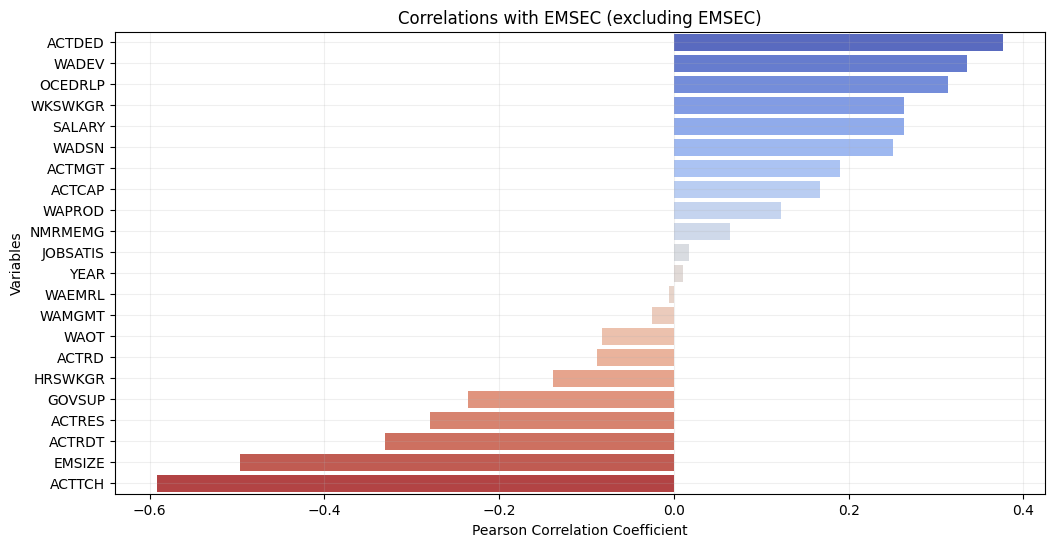

In [8]:
# Exclude 'EMSEC' from the plot
correlations = correlations[correlations.index != 'EMSEC']

# Create a bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.values, y=correlations.index, palette='coolwarm')
plt.title('Correlations with EMSEC (excluding EMSEC)')
plt.xlabel('Pearson Correlation Coefficient')
plt.ylabel('Variables')
plt.grid(alpha=0.2)
plt.show()

## Machine Learning Algorithms

In [9]:
# Check unique values in 'EMSEC' before mapping
print(df['EMSEC'].unique())

# Map values in 'EMSEC' to 0 and 1
df['EMSEC'] = df['EMSEC'].map({2: 0, 4: 1})

# Verify the unique values in 'EMSEC' after mapping
print(df['EMSEC'].unique())


[4 2]
[1 0]


In [10]:
# defining features and target columns
# df['EMSEC'] = df['EMSEC'].map({'2': 0, '4': 1})
X = df.drop('EMSEC', axis=1)
y = df['EMSEC']

In [11]:
# splitting data into train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In the literature, CART decision trees (Birzniece et al., 2022), kNN and SVM (Zebari et al., 2020), and XGBoost (Sheetal et al., 2022) algorithms have been used for supervised classification to answer related questions to ours. To re-iterate, the research questions is 'Can we predict which PhD holders will work in academia or industry? And what are their characteristics?'. This is a binary classification problem, so we will use relevant algorithms to build a binary prediction model, evaluate the performances, and extract the features of each class. We need to be mindful of the strengths and limitations of these algorithms also.

In [12]:
# defining some empty dfs to record metrics from each model and stage of analysis
column_names = ["method","accuracy","precision","recall","f1"]
train_results = pd.DataFrame(columns=column_names)
test_results = pd.DataFrame(columns=column_names)
hyp_train_results = pd.DataFrame(columns=column_names)
hyp_test_results = pd.DataFrame(columns=column_names)
train_confusion_matrices = []
test_confusion_matrices = []

## Baseline Models

### Decision Tree Classifier

In [13]:
# Create a decision tree classifier
dtc = DecisionTreeClassifier(random_state=42, max_leaf_nodes=len(X.columns))

# Train the classifier
dtc.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = dtc.predict(X_train)
y_pred_test = dtc.predict(X_test)

In [14]:
train_results, dtc_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "Decision Tree")
test_results, dtc_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "Decision Tree")
train_confusion_matrices.append(dtc_train_confusion)
test_confusion_matrices.append(dtc_test_confusion)

In [15]:
dtc.classes_

array([0, 1])

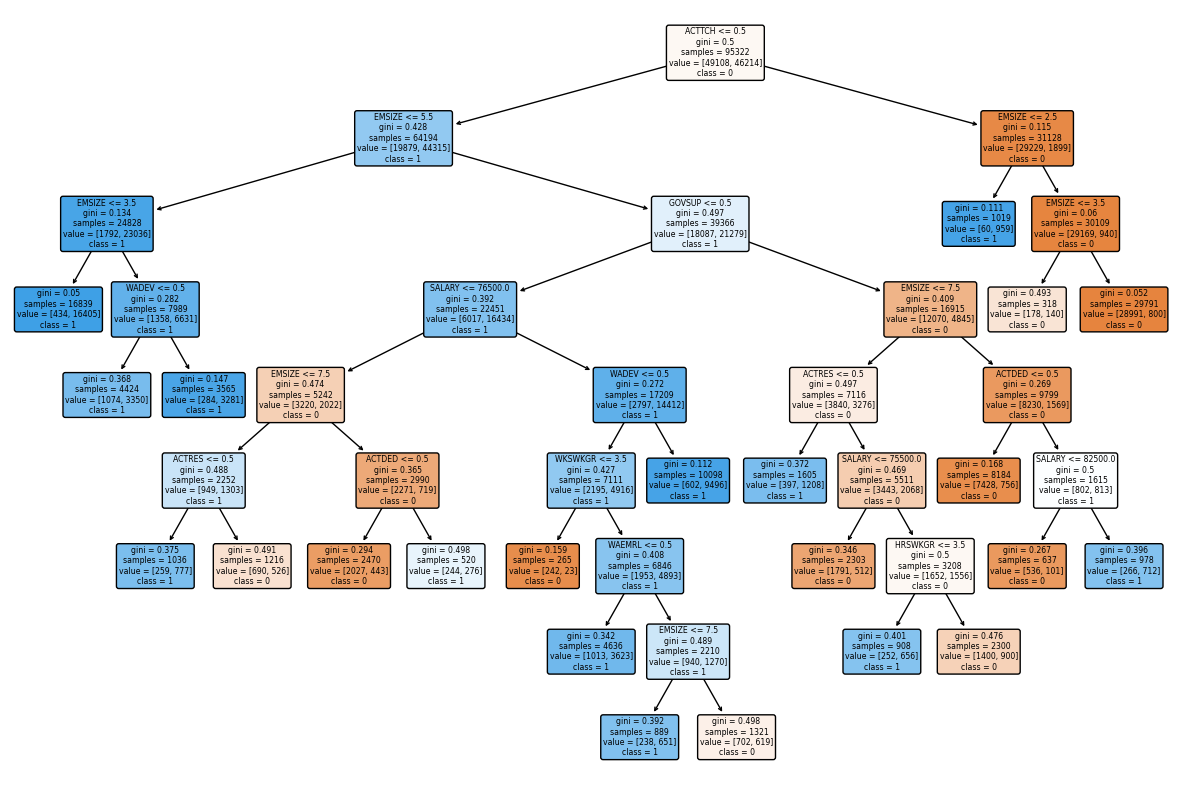

In [16]:
# Visualize the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(dtc, feature_names=X.columns, class_names=dtc.classes_.astype(str), filled=True, rounded=True)
plt.show()

In [17]:
dtc_feature_importances_df = create_feature_importances_df(dtc, X_test, y_test, data_dict)
dtc_feature_importances_df

,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.514449
1,EMSIZE,Size of employer,0.236799
2,GOVSUP,Federal government support indicator,0.118671
3,SALARY,Salary (annualized),0.064293
4,WADEV,Work activities on principal job: development,0.019293
5,ACTDED,"Activity, development and design",0.017408
6,ACTRES,"Activity, research (basic and/or applied)",0.014463
7,WKSWKGR,Principal job weeks salary based on year (group),0.006233
8,HRSWKGR,Principal job: hours per week typically worked...,0.004424
9,WAEMRL,Work activities on principal job: employee rel...,0.003967


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


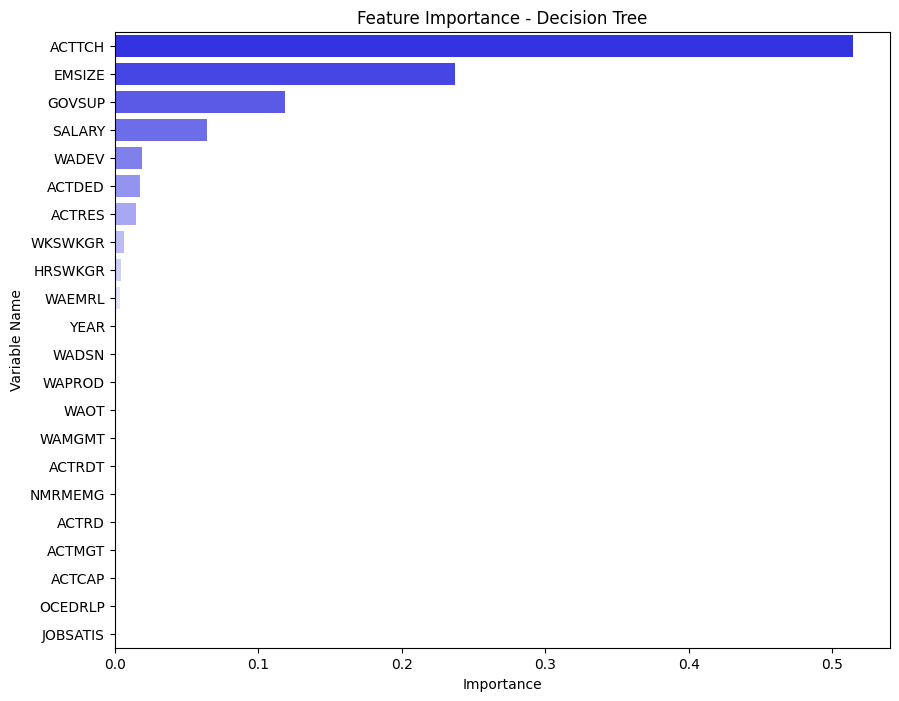

In [18]:
visualize_feature_importance(dtc_feature_importances_df, 'Decision Tree')

### SVM

In [19]:
# # Define and train the SVM model
# svm_model = SVC(kernel='rbf')  # You can choose different kernels based on your data
# svm_model.fit(X_train, y_train)

# # Make predictions on the test set
# y_pred = svm_model.predict(X_test)

# # Evaluate the accuracy
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

Executing the SVM model was taking too long due to my hardware constraints, so I did not use SVM in my analysis. Future research will include SVM, once I figure out how to bypass my hardware constraints.

### XGBoost

In [20]:
# Define the XGBoost model
xgb = xgb.XGBClassifier(objective='binary:logistic', random_state=42)

# Train the model
xgb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = xgb.predict(X_train)

# Make predictions on the test set
y_pred_test = xgb.predict(X_test)

In [21]:
train_results, xgb_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "XGBoost")
test_results, xgb_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "XGBoost")
train_confusion_matrices.append(xgb_train_confusion)
test_confusion_matrices.append(xgb_test_confusion)

In [22]:
# Extract feature importances
xgb_feature_importances_df = pd.DataFrame({'Importance': xgb.feature_importances_}, index=X_train.columns)

# Sort feature importances in descending order
xgb_feature_importances_df = xgb_feature_importances_df.sort_values(by='Importance', ascending=False)

# Assuming your feature names are in X_train.columns
xgb_feature_importances_df['Variable Name'] = xgb_feature_importances_df.index
xgb_feature_importances_df.reset_index(drop=True, inplace=True)

# Map variable descriptions to feature names
xgb_feature_importances_df['Short Description'] = xgb_feature_importances_df['Variable Name'].map(data_dict)

# Extract the values from the dictionary in 'Short Description'
xgb_feature_importances_df['Short Description'] = xgb_feature_importances_df['Short Description'].apply(lambda x: x.get('var_desc_short', ''))

# Reorder columns
xgb_feature_importances_df = xgb_feature_importances_df[['Variable Name', 'Short Description', 'Importance']]

# Display the final DataFrame
xgb_feature_importances_df


,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.587272
1,EMSIZE,Size of employer,0.075763
2,GOVSUP,Federal government support indicator,0.074001
3,ACTDED,"Activity, development and design",0.060349
4,WADEV,Work activities on principal job: development,0.032614
5,ACTRES,"Activity, research (basic and/or applied)",0.026129
6,WKSWKGR,Principal job weeks salary based on year (group),0.025392
7,SALARY,Salary (annualized),0.014669
8,OCEDRLP,Principal job related to highest degree,0.012765
9,ACTCAP,"Activity, computer applications",0.011750


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


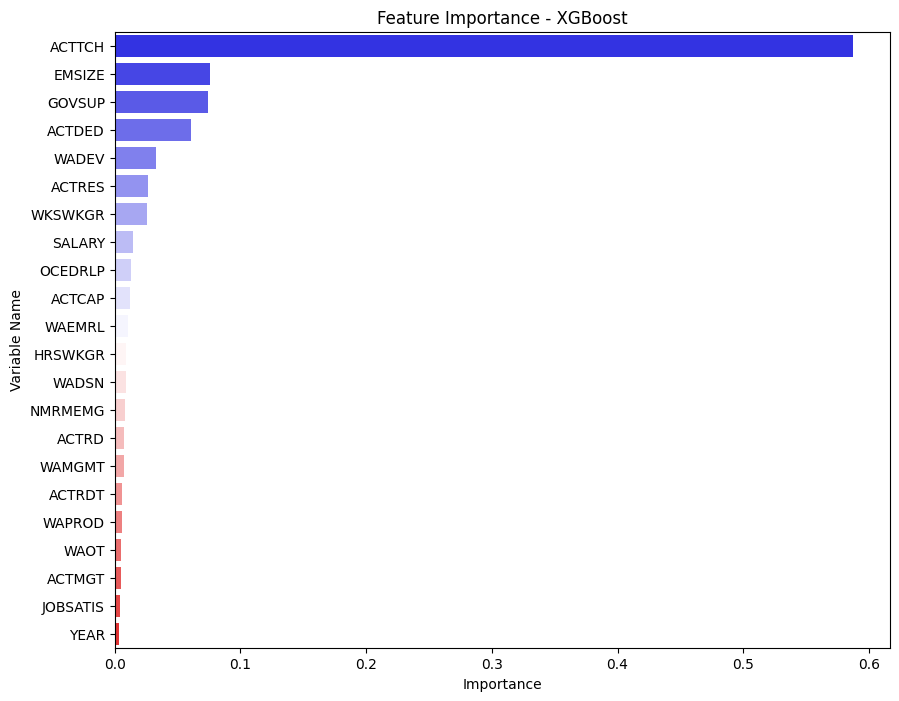

In [23]:
visualize_feature_importance(xgb_feature_importances_df, 'XGBoost')

We used Decision Tree and XGBoost because the literature used it. We tried SVM but our technological limitations would not allow its usage. We will now try some other algorithms that solve the task.

### Random Forest Classifier

In [24]:
# Create a random forest classifier
rf = RandomForestClassifier()

# Train the classifier
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = rf.predict(X_train)
y_pred_test = rf.predict(X_test)

# Save results
train_results, rf_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "Random Forest")
test_results, rf_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "Random Forest")
train_confusion_matrices.append(rf_train_confusion)
test_confusion_matrices.append(rf_test_confusion)

In [25]:
rf_feature_importances_df = create_feature_importances_df(rf, X_test, y_test, data_dict)
rf_feature_importances_df

,Variable Name,Short Description,Importance
0,EMSIZE,Size of employer,0.208312
1,ACTTCH,"Activity, teaching",0.178139
2,SALARY,Salary (annualized),0.133285
3,ACTDED,"Activity, development and design",0.059856
4,GOVSUP,Federal government support indicator,0.045723
5,NMRMEMG,Field of study of major for most recent degree...,0.043261
6,WADEV,Work activities on principal job: development,0.042496
7,ACTRDT,"Activity, research, development, and teaching",0.041055
8,YEAR,Survey year,0.037082
9,WKSWKGR,Principal job weeks salary based on year (group),0.035072


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


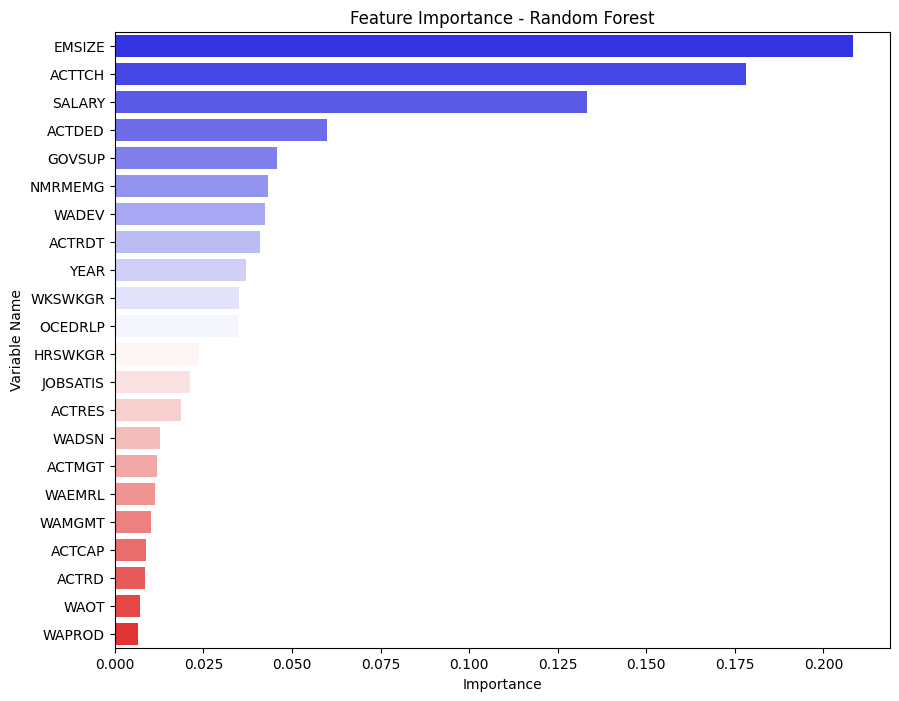

In [26]:
visualize_feature_importance(rf_feature_importances_df, 'Random Forest')

### Logistic Regression Classifier

In [27]:
# Create a logistic regression classifier
logreg = LogisticRegression()

# Train the classifier
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = logreg.predict(X_train)
y_pred_test = logreg.predict(X_test)

# Save results
train_results, logreg_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "Logistic Regression")
test_results, logreg_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "Logistic Regression")
train_confusion_matrices.append(logreg_train_confusion)
test_confusion_matrices.append(logreg_test_confusion)

In [28]:
lr_feature_importances = pd.Series(logreg.coef_[0], index=X_train.columns)
lr_feature_importances = lr_feature_importances.abs().sort_values(ascending=False)
lr_feature_importances_df = create_feature_importances_df_lr(logreg, data_dict, lr_feature_importances)
lr_feature_importances_df

,Variable Name,Short Description,Importance
0,YEAR,Survey year,6.417516e-04
1,SALARY,Salary (annualized),1.387926e-05
2,EMSIZE,Size of employer,5.825904e-06
3,HRSWKGR,Principal job: hours per week typically worked...,1.516120e-06
4,ACTTCH,"Activity, teaching",9.795623e-07
5,WKSWKGR,Principal job weeks salary based on year (group),8.575106e-07
6,NMRMEMG,Field of study of major for most recent degree...,8.106589e-07
7,ACTRDT,"Activity, research, development, and teaching",6.822669e-07
8,ACTRES,"Activity, research (basic and/or applied)",6.151202e-07
9,GOVSUP,Federal government support indicator,4.749320e-07


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


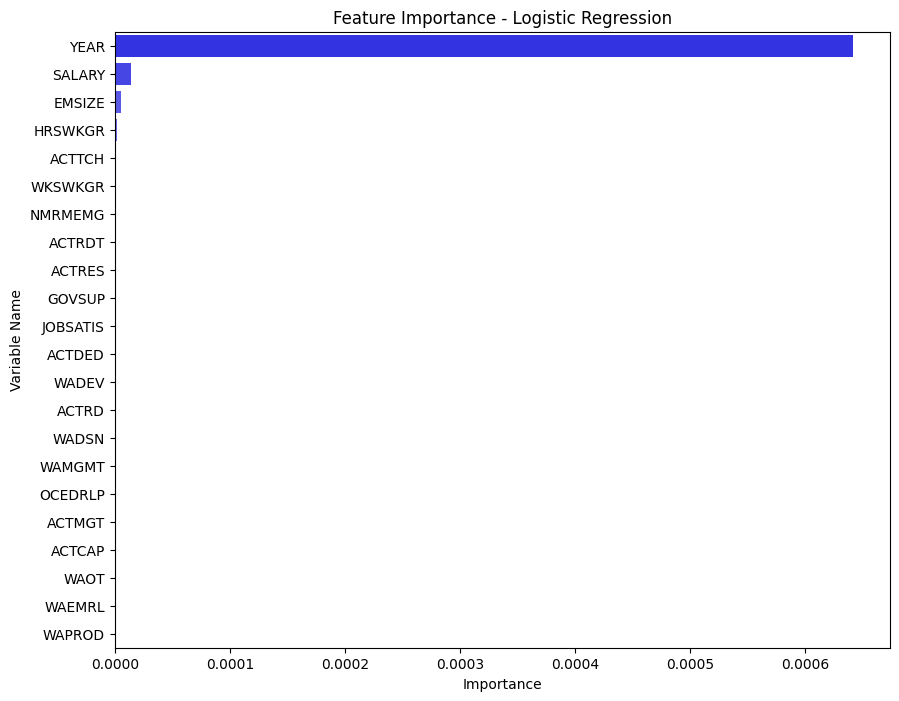

In [29]:
visualize_feature_importance(lr_feature_importances_df, 'Logistic Regression')

### k-Nearest Neighbors Classifier

In [30]:
# Create a KNN classifier
knn = KNeighborsClassifier()

# Train the classifier
knn.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

# Save results
train_results, knn_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "KNN")
test_results, knn_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "KNN")
train_confusion_matrices.append(knn_train_confusion)
test_confusion_matrices.append(knn_test_confusion)

In [31]:
# Example usage for KNN
knn_feature_importances_df = create_feature_importances_df_knn(knn, X_test, y_test, data_dict)
knn_feature_importances_df

,Variable Name,Short Description,Importance
0,EMSIZE,Size of employer,0.157961
1,SALARY,Salary (annualized),0.152071
2,YEAR,Survey year,0.034915
3,ACTTCH,"Activity, teaching",0.015547
4,NMRMEMG,Field of study of major for most recent degree...,0.011264
5,GOVSUP,Federal government support indicator,0.007894
6,ACTDED,"Activity, development and design",0.006981
7,WADEV,Work activities on principal job: development,0.006690
8,OCEDRLP,Principal job related to highest degree,0.006554
9,HRSWKGR,Principal job: hours per week typically worked...,0.005275


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


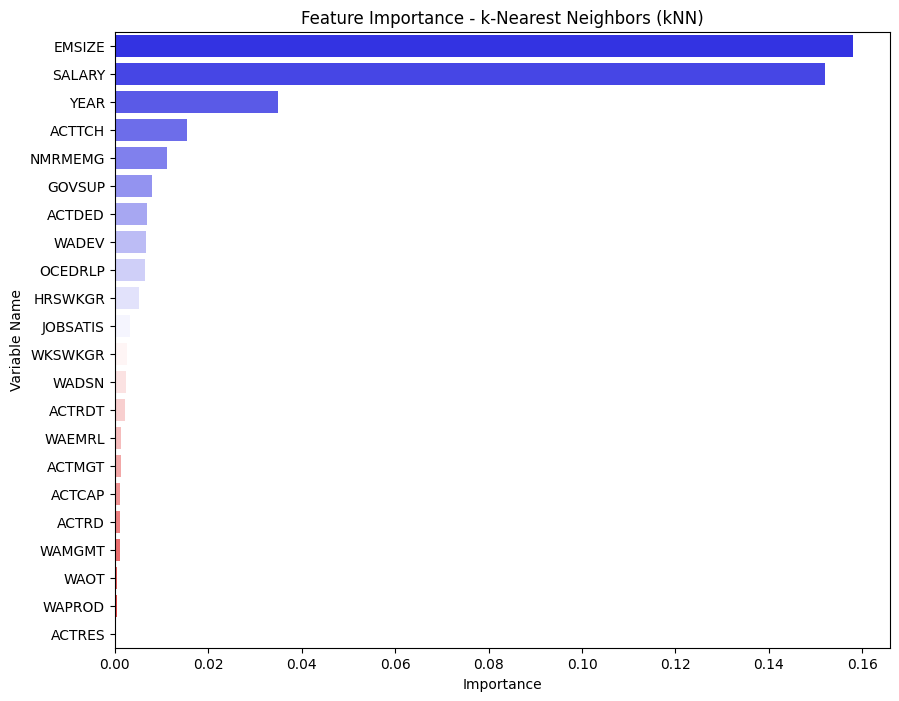

In [32]:
visualize_feature_importance(knn_feature_importances_df, 'k-Nearest Neighbors (kNN)')

### Gradient Boosting Classifier

In [33]:
# Create a gradient boosting classifier
gb = GradientBoostingClassifier()

# Train the classifier
gb.fit(X_train, y_train)

# Make predictions on the test set
y_pred_train = gb.predict(X_train)
y_pred_test = gb.predict(X_test)

# Save results
train_results, gb_train_confusion = save_results_to_df(train_results, y_train, y_pred_train, "Gradient Boosting")
test_results, gb_test_confusion = save_results_to_df(test_results, y_test, y_pred_test, "Gradient Boosting")
train_confusion_matrices.append(gb_train_confusion)
test_confusion_matrices.append(gb_test_confusion)

In [34]:
gb_feature_importances_df = create_feature_importances_df(gb, X_test, y_test, data_dict)
gb_feature_importances_df

,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.456533
1,EMSIZE,Size of employer,0.256068
2,GOVSUP,Federal government support indicator,0.087692
3,SALARY,Salary (annualized),0.068617
4,ACTDED,"Activity, development and design",0.046958
5,WADEV,Work activities on principal job: development,0.021437
6,ACTRES,"Activity, research (basic and/or applied)",0.015035
7,OCEDRLP,Principal job related to highest degree,0.013077
8,WKSWKGR,Principal job weeks salary based on year (group),0.010445
9,NMRMEMG,Field of study of major for most recent degree...,0.004942


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Variable Name', data=feature_importances_df, palette='bwr')


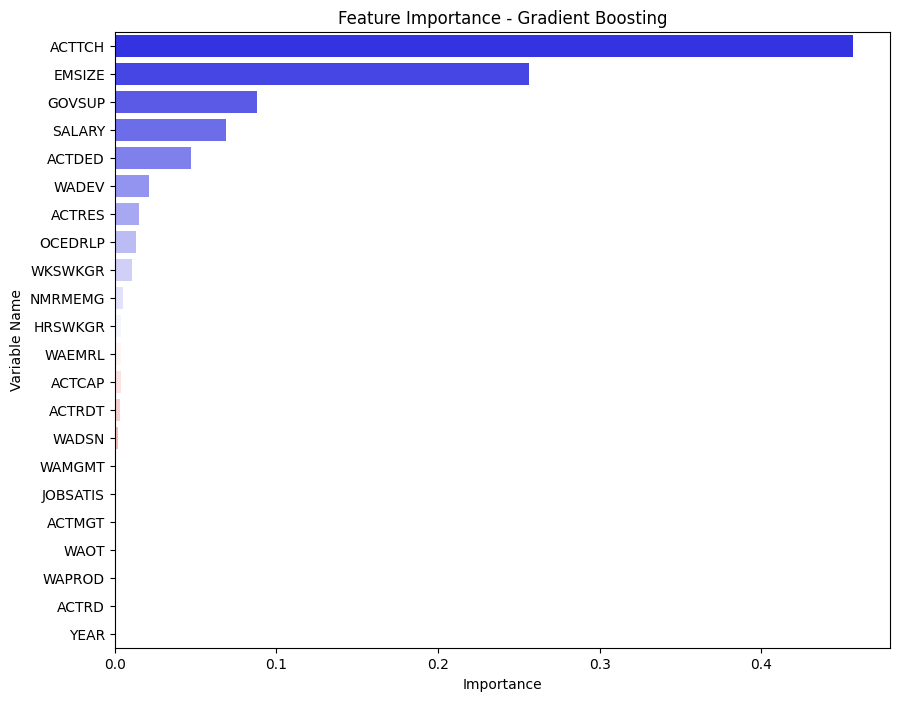

In [35]:
visualize_feature_importance(gb_feature_importances_df, 'Gradient Boosting')

### Examining Results

In [36]:
# Examining the evaluation metrics
train_results

,method,accuracy,precision,recall,f1
0,Decision Tree,0.895690,0.889868,0.895703,0.892776
1,XGBoost,0.932880,0.926716,0.935539,0.931107
2,Random Forest,0.996811,0.997034,0.996386,0.996710
3,Logistic Regression,0.651675,0.655951,0.592093,0.622389
4,KNN,0.907430,0.923865,0.881724,0.902303
5,Gradient Boosting,0.911888,0.903481,0.916129,0.909761


/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])


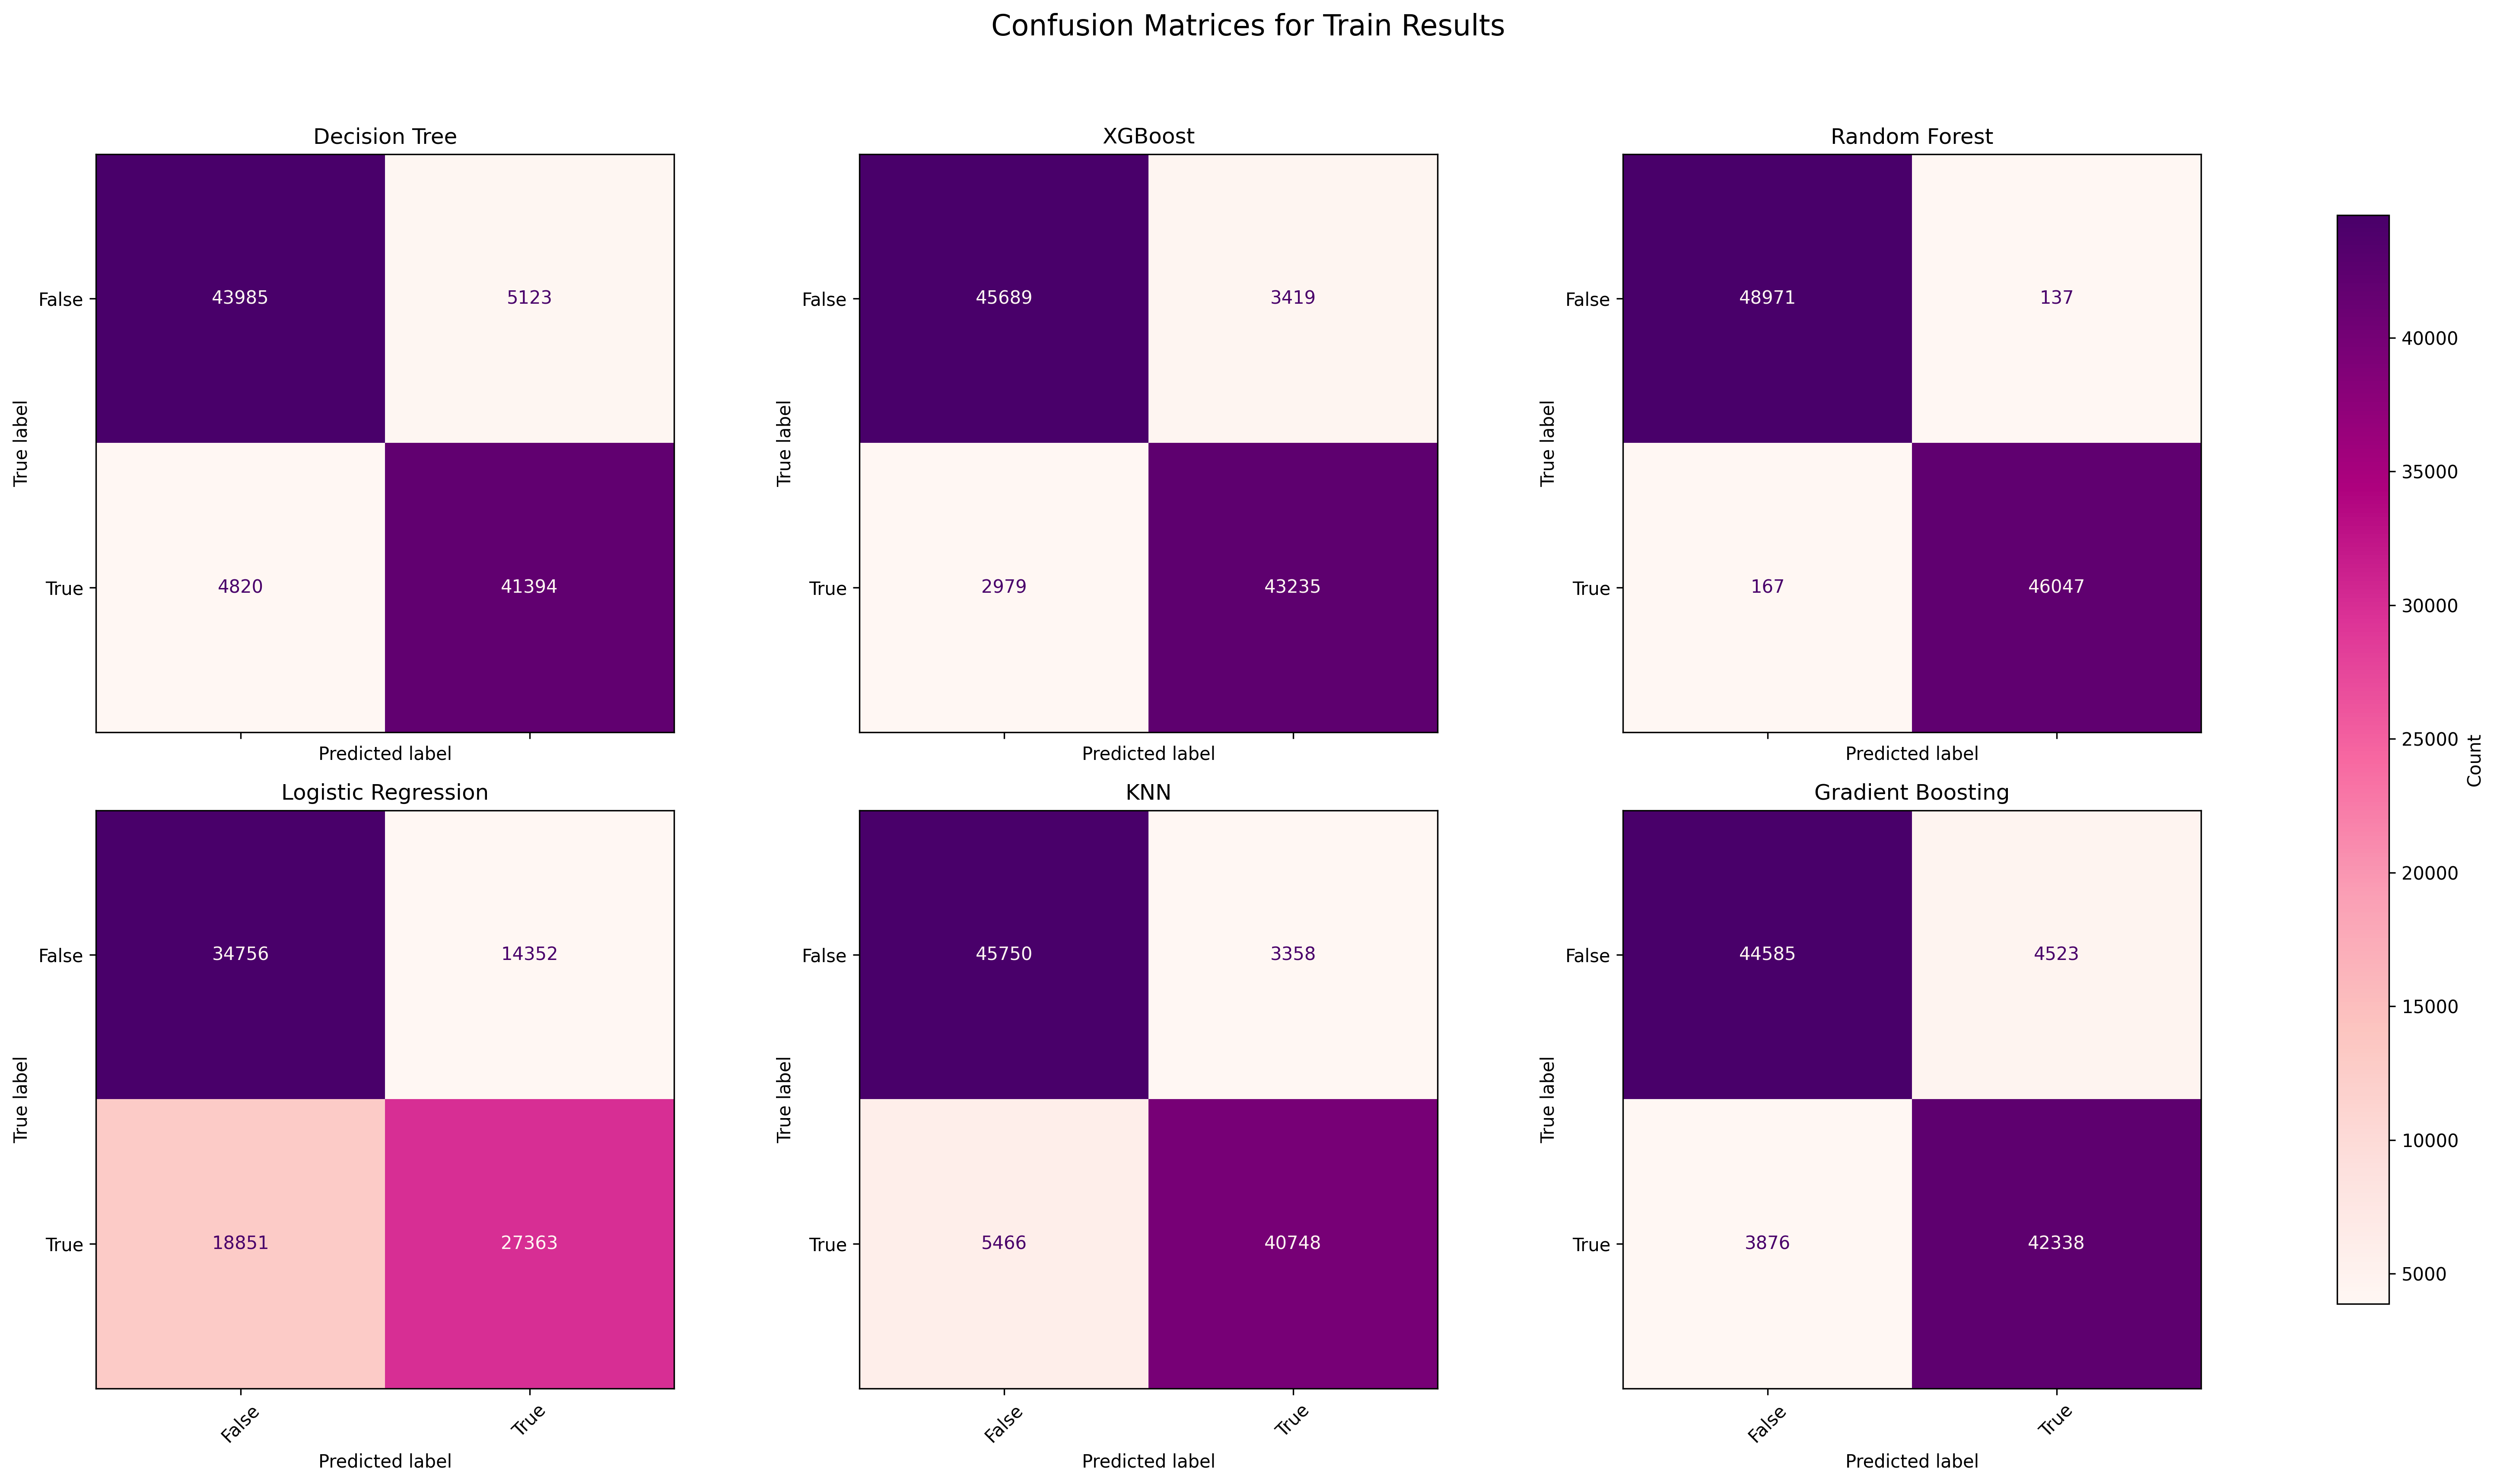

In [37]:
# plotting training confusion matrices
classifiers = ['Decision Tree', 'XGBoost', 'Random Forest', 'Logistic Regression', 'KNN', 'Gradient Boosting']
plot_confusion_matrices(train_confusion_matrices, classifiers, "Train")

/Users/av15397n/Documents/GitHub/CS668-Capstone-Project/code/utils.py:76: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 0.9, 0.95])


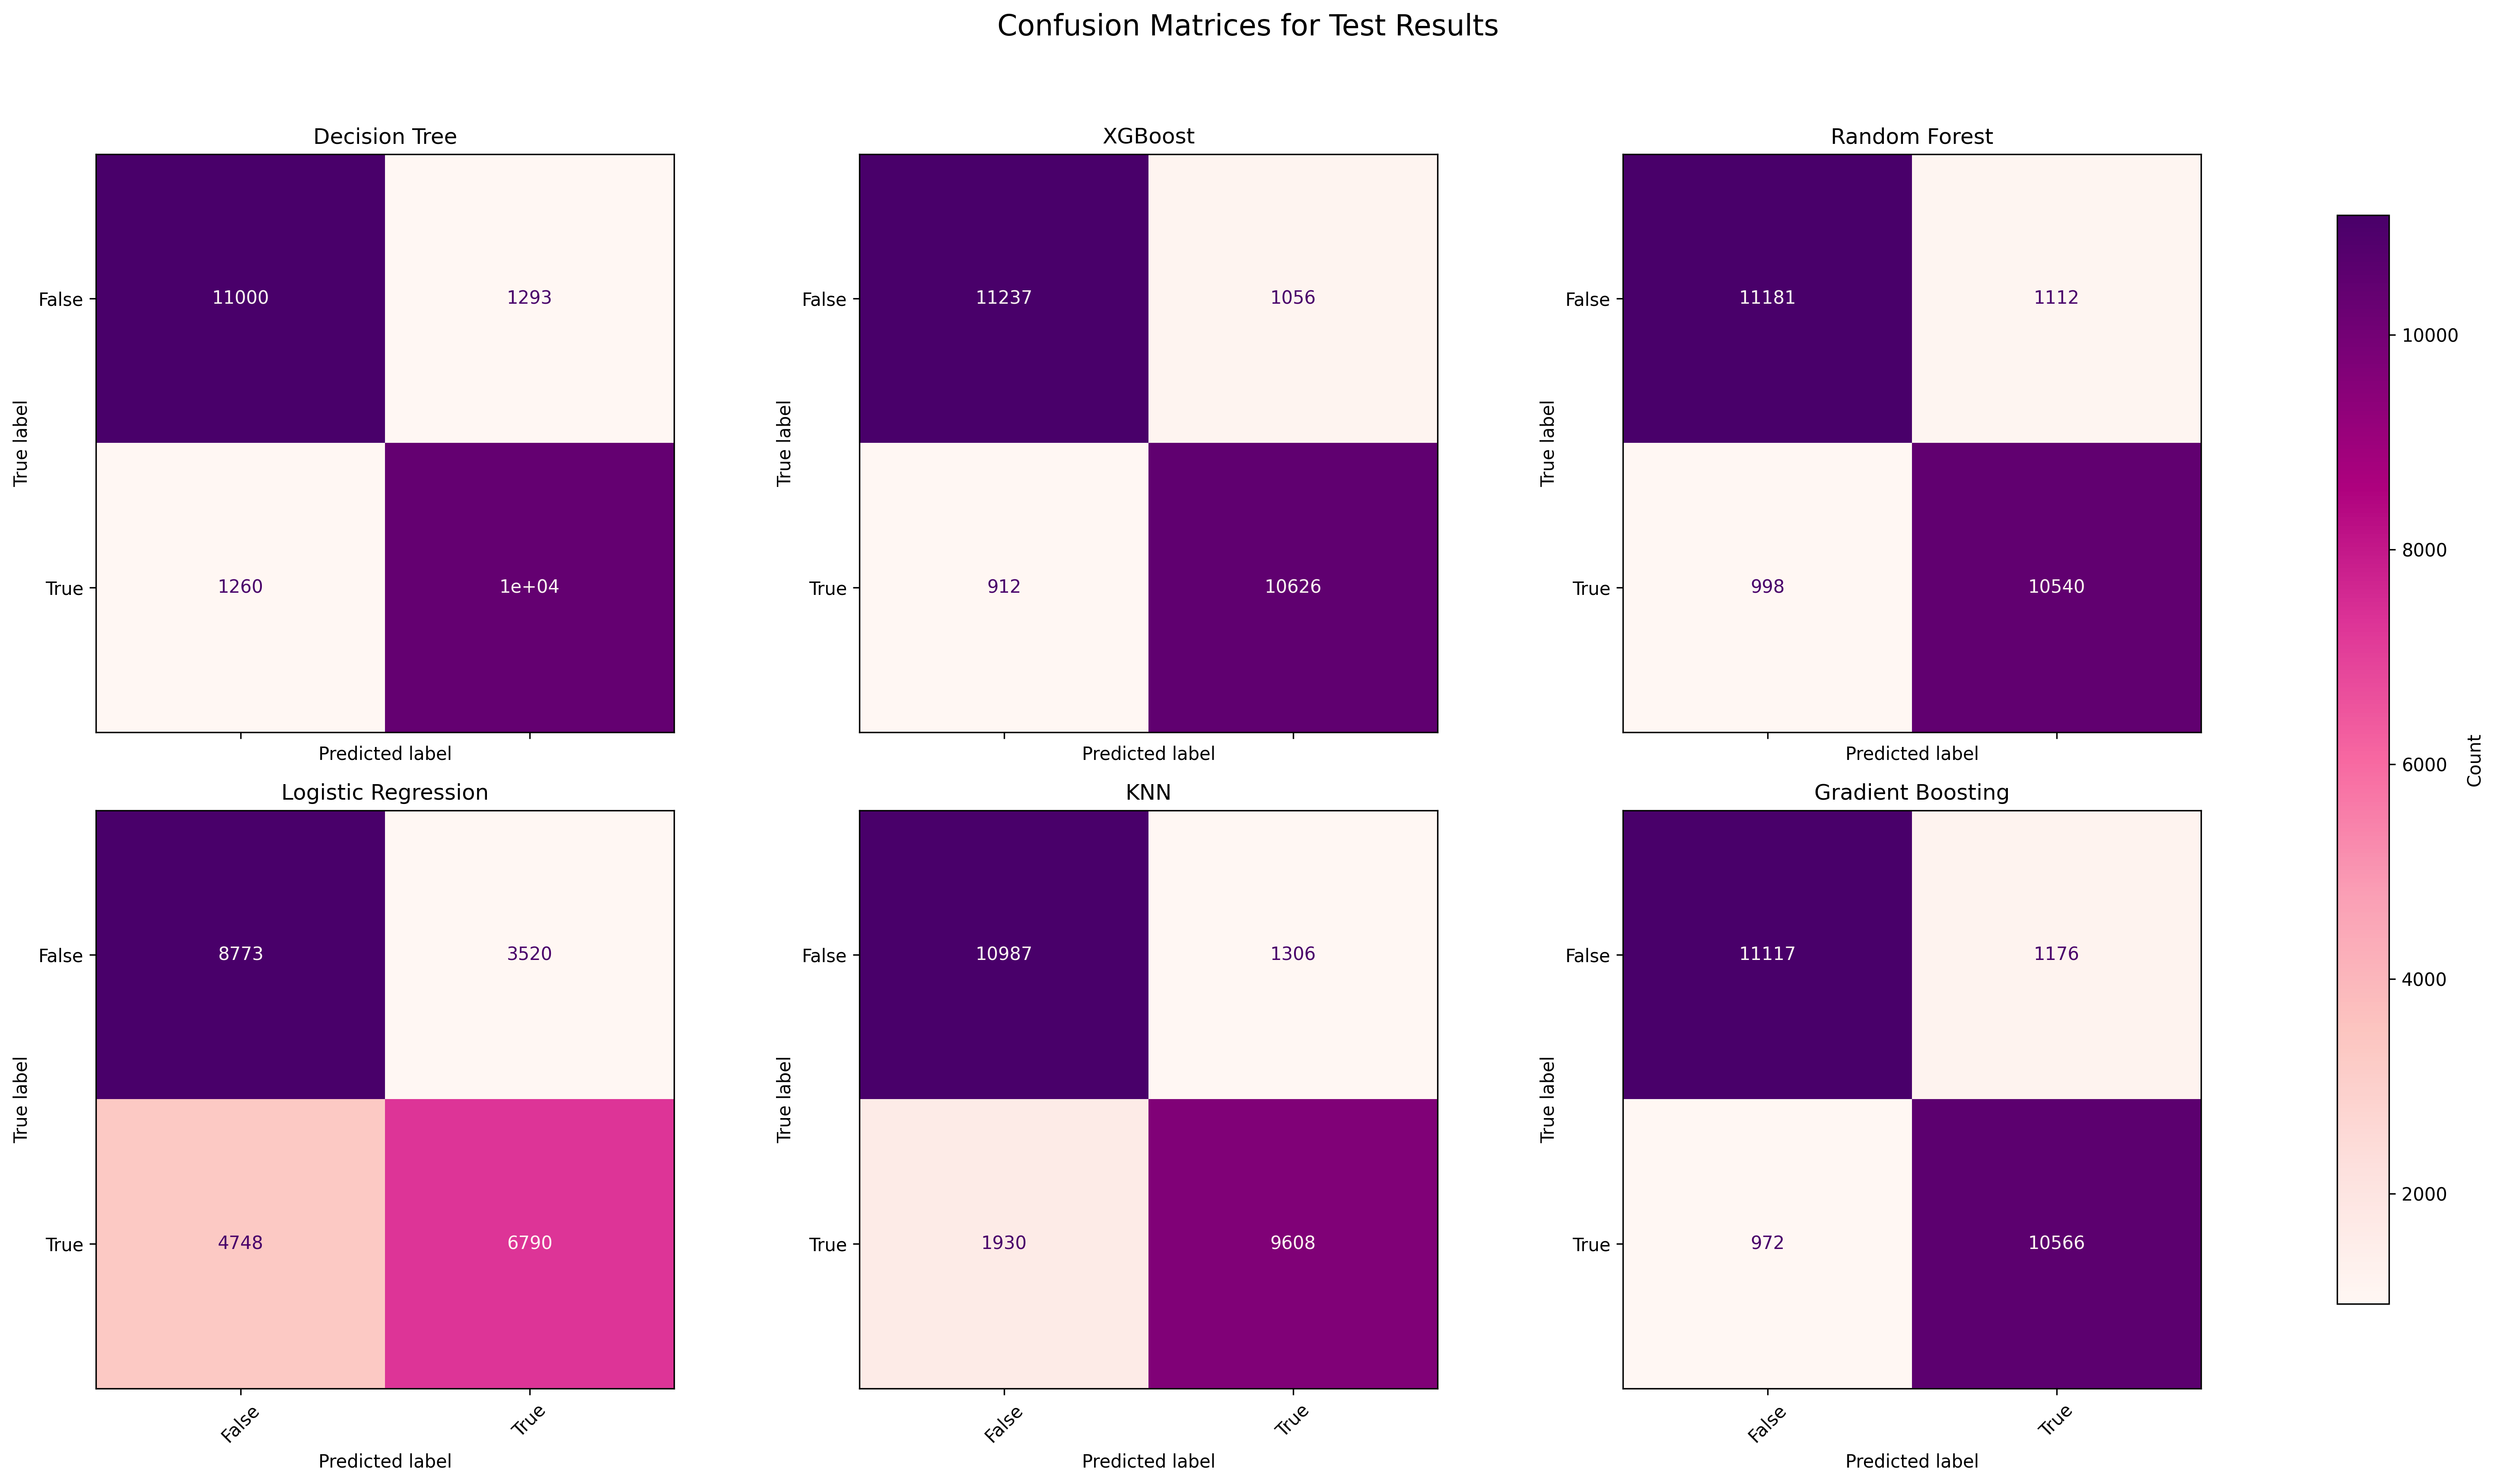

In [38]:
# plotting test confusion matrices
plot_confusion_matrices(test_confusion_matrices, classifiers, "Test")

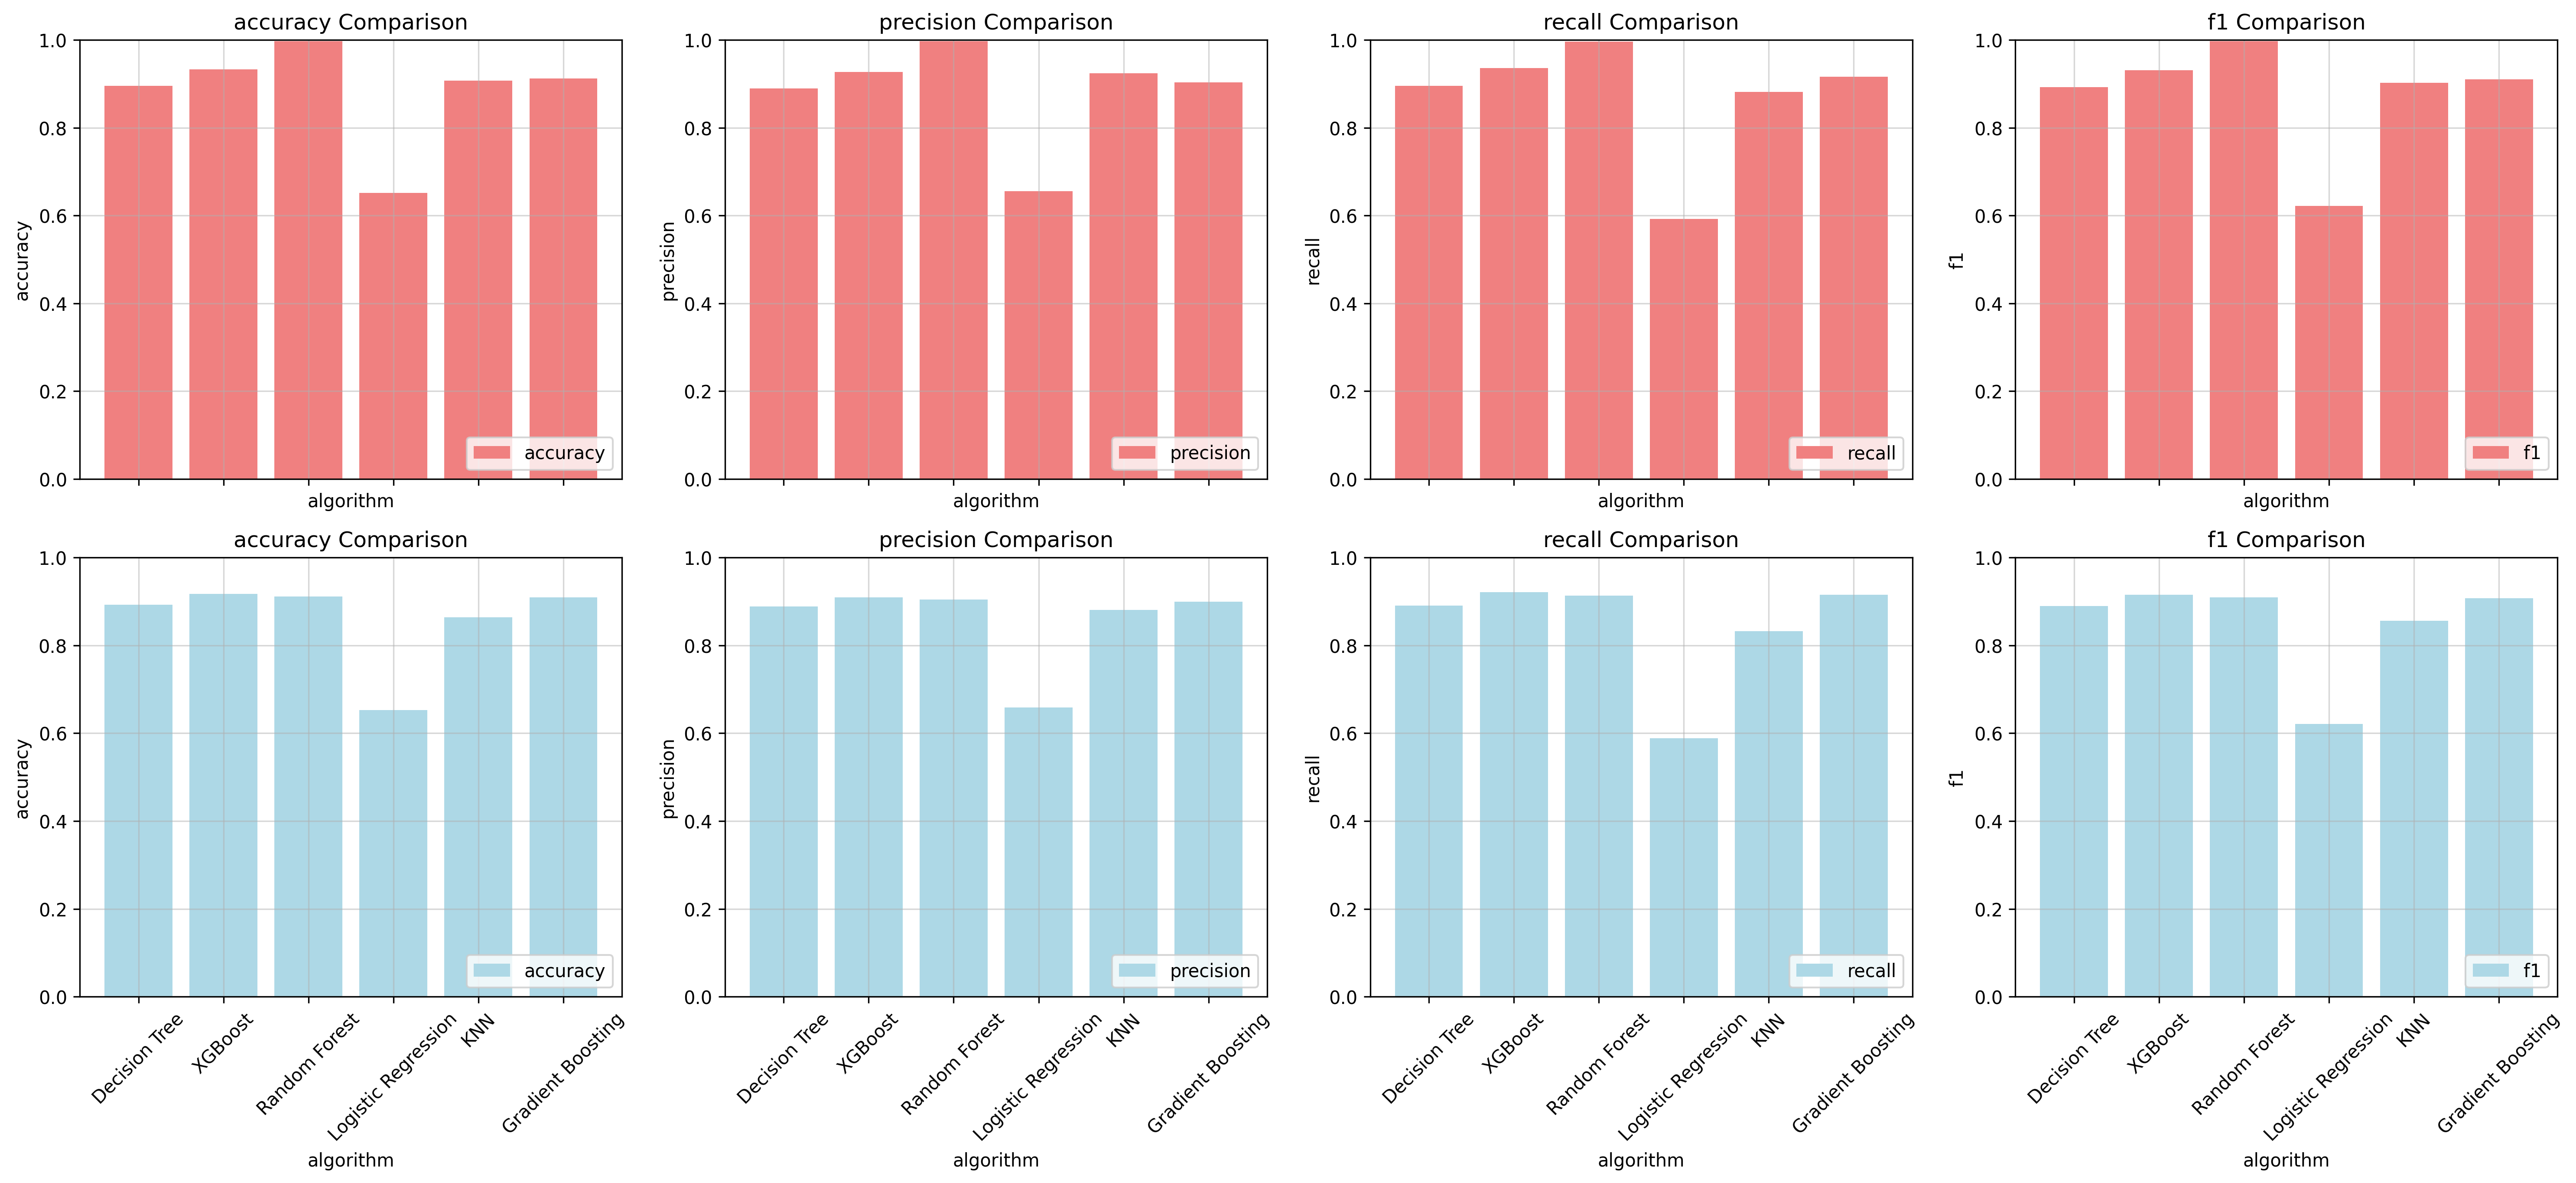

In [39]:
fig, ax = plt.subplots(2, 4, sharex=True, sharey=False, figsize=(20, 10), dpi=300)
x_labels = train_results['method']
indices = np.arange(len(x_labels))
width = 0.3

# Plotting for Train Results (first row)
for i in range(4):
    # row=0
    ax[0, i].bar(indices, train_results.iloc[:, i + 1], color="lightcoral", alpha=1, label=train_results.columns[i + 1])
    ax[0, i].grid(True, alpha=0.5)
    ax[0, i].set_ylim(0, 1)
    ax[0, i].set_xlabel("algorithm")
    ax[0, i].set_ylabel(train_results.columns[i + 1])
    ax[0, i].set_title(f"{train_results.columns[i + 1]} Comparison")
    ax[0, i].legend(loc='lower right')
    ax[0, i].set_xticks(indices, x_labels, rotation=45)

# Plotting for Test Results (second row)
for i in range(4):
    # row=1
    ax[1, i].bar(indices, test_results.iloc[:, i + 1], color="lightblue", alpha=1, label=test_results.columns[i + 1])
    ax[1, i].grid(True, alpha=0.5)
    ax[1, i].set_ylim(0, 1)
    ax[1, i].set_xlabel("algorithm")
    ax[1, i].set_ylabel(test_results.columns[i + 1])
    ax[1, i].set_title(f"{test_results.columns[i + 1]} Comparison")
    ax[1, i].legend(loc='lower right')
    ax[1, i].set_xticks(indices, x_labels, rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


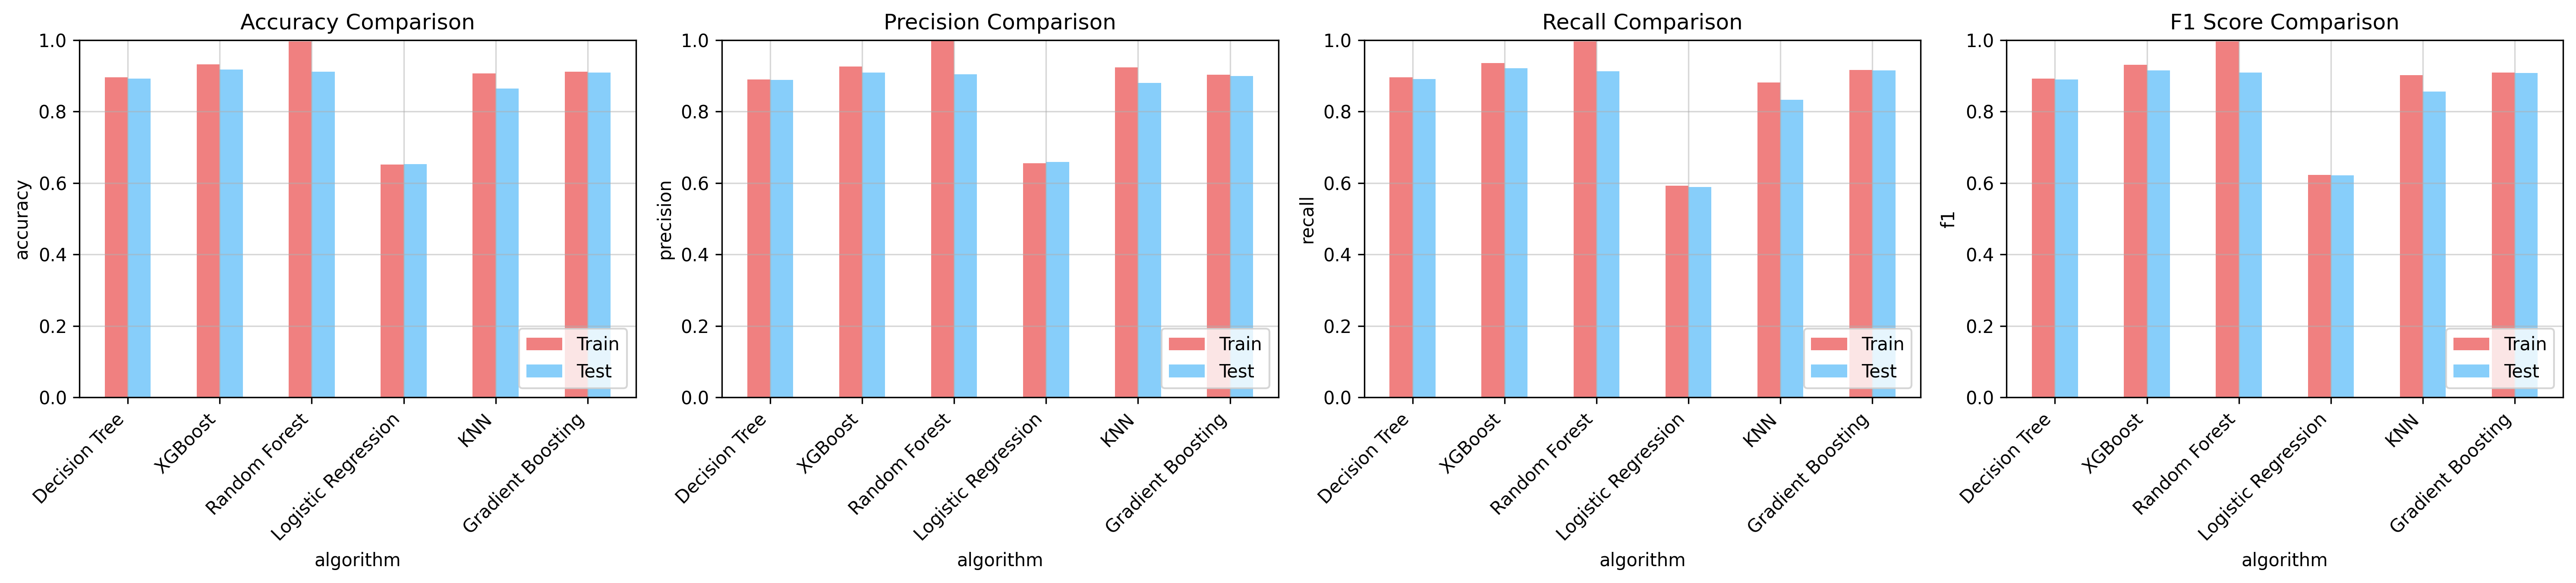

In [40]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=False, figsize=(20, 5), dpi=300)
x_labels = train_results['method']
indices = range(len(x_labels))
width = 0.25

# Plotting for Accuracy (col=0)
ax[0].bar(indices, train_results['accuracy'], width, color="lightcoral", alpha=1, label="Train")
ax[0].bar([i + width for i in indices], test_results['accuracy'], width, color="lightskyblue", alpha=1, label="Test")
ax[0].grid(True, alpha=0.5)
ax[0].set_ylim(0, 1)
ax[0].set_xlabel("algorithm")
ax[0].set_ylabel("accuracy")
ax[0].set_title("Accuracy Comparison")
ax[0].legend(loc='lower right')
ax[0].set_xticks([i + width/2 for i in indices])
ax[0].set_xticklabels(x_labels, rotation=45, ha='right')

# Plotting for Precision (col=1)
ax[1].bar(indices, train_results['precision'], width, color="lightcoral", alpha=1, label="Train")
ax[1].bar([i + width for i in indices], test_results['precision'], width, color="lightskyblue", alpha=1, label="Test")
ax[1].grid(True, alpha=0.5)
ax[1].set_ylim(0, 1)
ax[1].set_xlabel("algorithm")
ax[1].set_ylabel("precision")
ax[1].set_title("Precision Comparison")
ax[1].legend(loc='lower right')
ax[1].set_xticks([i + width/2 for i in indices])
ax[1].set_xticklabels(x_labels, rotation=45, ha='right')

# Plotting for Recall (col=2)
ax[2].bar(indices, train_results['recall'], width, color="lightcoral", alpha=1, label="Train")
ax[2].bar([i + width for i in indices], test_results['recall'], width, color="lightskyblue", alpha=1, label="Test")
ax[2].grid(True, alpha=0.5)
ax[2].set_ylim(0, 1)
ax[2].set_xlabel("algorithm")
ax[2].set_ylabel("recall")
ax[2].set_title("Recall Comparison")
ax[2].legend(loc='lower right')
ax[2].set_xticks([i + width/2 for i in indices])
ax[2].set_xticklabels(x_labels, rotation=45, ha='right')

# Plotting for F1 Score (col=3)
ax[3].bar(indices, train_results['f1'], width, color="lightcoral", alpha=1, label="Train")
ax[3].bar([i + width for i in indices], test_results['f1'], width, color="lightskyblue", alpha=1, label="Test")
ax[3].grid(True, alpha=0.5)
ax[3].set_ylim(0, 1)
ax[3].set_xlabel("algorithm")
ax[3].set_ylabel("f1")
ax[3].set_title("F1 Score Comparison")
ax[3].legend(loc='lower right')
ax[3].set_xticks([i + width/2 for i in indices])
ax[3].set_xticklabels(x_labels, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

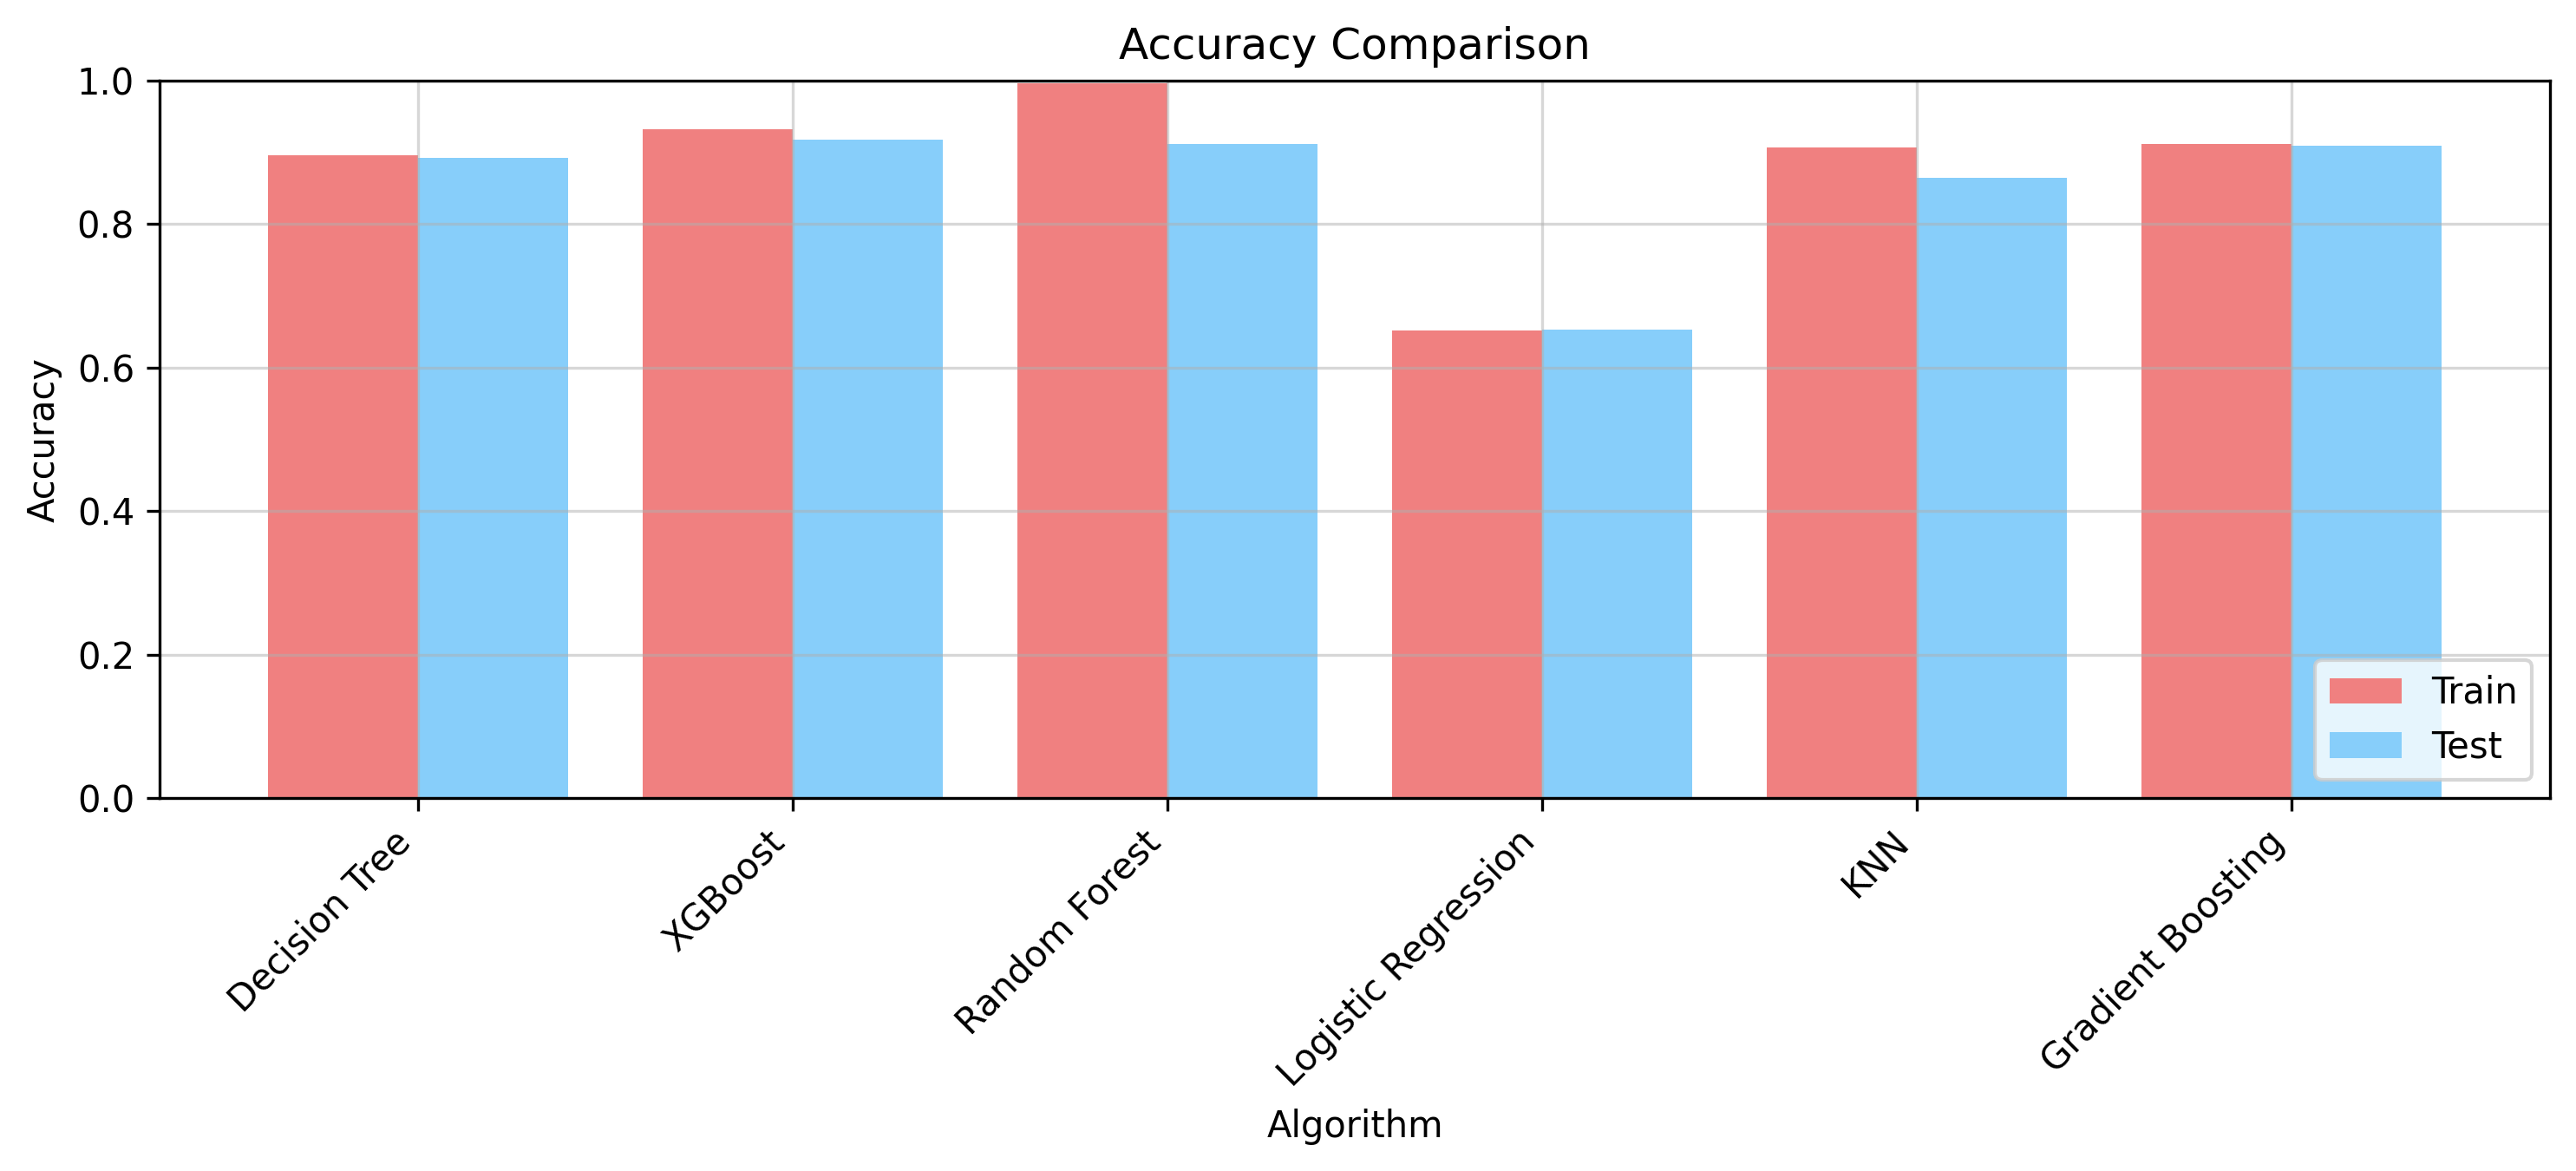

In [41]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
x_labels = train_results['method']
indices = range(len(x_labels))
width = 0.4

# Plotting for Accuracy
ax.bar(indices, train_results['accuracy'], width, color="lightcoral", alpha=1, label="Train")
ax.bar([i + width for i in indices], test_results['accuracy'], width, color="lightskyblue", alpha=1, label="Test")
ax.grid(True, alpha=0.5)
ax.set_ylim(0, 1)
ax.set_xlabel("Algorithm")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy Comparison")
ax.legend(loc='lower right')
ax.set_xticks([i + width/2 for i in indices])
ax.set_xticklabels(x_labels, rotation=45, ha='right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [42]:
# Create a DataFrame with algorithm, train accuracy, and test accuracy
results_df = pd.DataFrame({
    'algorithm': x_labels,
    'train_accuracy': train_results['accuracy'].round(3),
    'test_accuracy': test_results['accuracy'].round(3),
    'loss': train_results['accuracy'].round(3) - test_results['accuracy'].round(3)
})
results_df

,algorithm,train_accuracy,test_accuracy,loss
0,Decision Tree,0.896,0.893,0.003
1,XGBoost,0.933,0.917,0.016
2,Random Forest,0.997,0.911,0.086
3,Logistic Regression,0.652,0.653,-0.001
4,KNN,0.907,0.864,0.043
5,Gradient Boosting,0.912,0.910,0.002


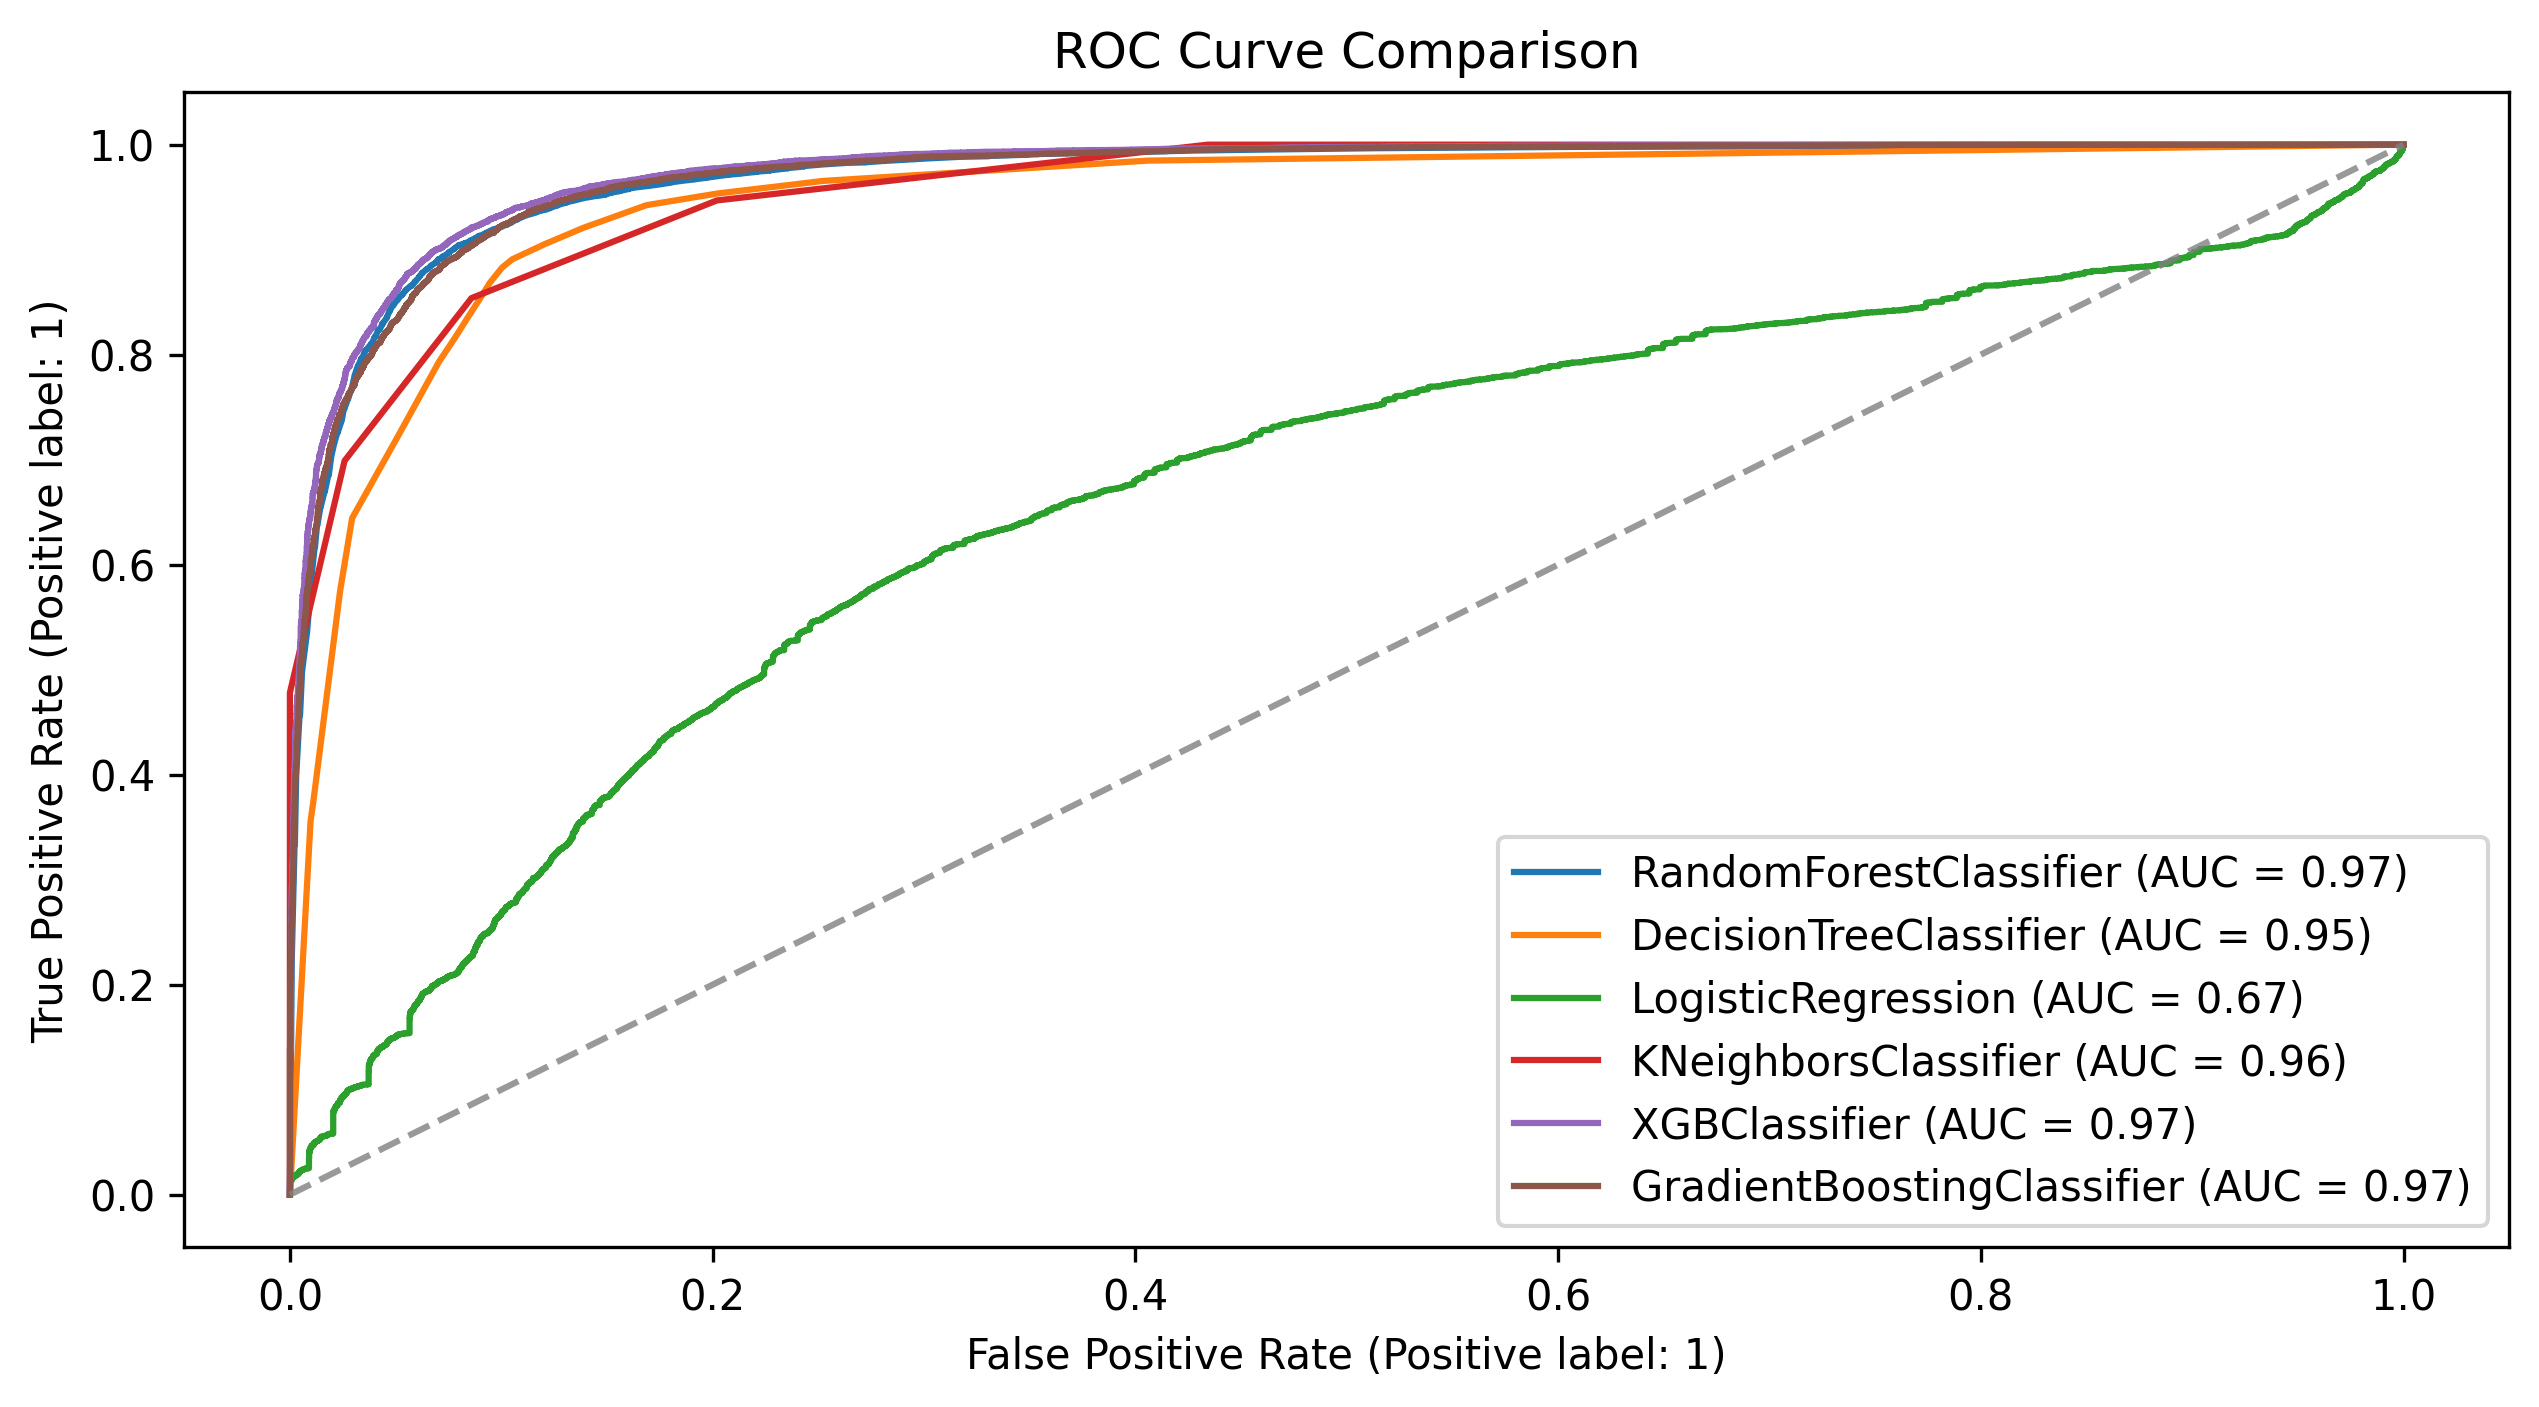

In [43]:
classifiers = [rf, dtc, logreg, knn, xgb, gb]

# Plotting ROC curves with AUC scores using RocCurveDisplay
fig, ax = plt.subplots(figsize=(10, 5), dpi=300)
for clf in classifiers:
    RocCurveDisplay.from_estimator(clf, X_test, y_test, ax=ax)

# Adding a dotted line for AUC of 0.5
ax.plot([0, 1], [0, 1], linestyle='--', color='grey', label='Random', alpha=0.8)

ax.set_title("ROC Curve Comparison")
plt.show()

In [44]:
classifiers = [rf, dtc, logreg, knn, xgb, gb]

# Lists to store results
x_labels = []
train_acc = []
test_acc = []
loss = []
auc_scores = []

for clf in classifiers:
    # Train the model
    clf.fit(X_train, y_train)

    # Predictions on the training set
    y_train_pred = clf.predict(X_train)
    # Predictions on the test set
    y_test_pred = clf.predict(X_test)

    # AUC score
    auc_score = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    auc_scores.append(auc_score)

In [45]:
# Create a DataFrame
results_df = pd.DataFrame({
    'algorithm': train_results['method'],
    'train_accuracy': train_results['accuracy'].round(3),
    'test_accuracy': test_results['accuracy'].round(3),
    'accuracy_loss': train_results['accuracy'].round(3) - test_results['accuracy'].round(3),
    'auc_score': np.round(auc_scores, 3)  # Adding AUC scores as a new column
})
# Sort results_df by auc_score in descending order
results_df = results_df.sort_values(by='auc_score', ascending=False).reset_index(drop=True)

### Model Evaluation

For our research problem, our aim is to find the best possible algorithm which classifies a PhD holder's employment sector being either academia or industry. We used 6 algorithms and evaluated their performances. Now we will discuss a few evaluation metrics to judge the best algorithm that should be used to predict employment sector classifications for PhD holders in the IPUMS Higher Ed dataset. 

But first, some terminology! Most evaluation metrics are defined in terms of positives and negatives, as seen in the confusion matrices. In our confusion matrix for our binary classification problem, a positive is defined as 1, which corresponds to class 'industry'. Therefore, the negative class corresponds to 0, which corresponds to class 'academia'. This tells us that our models are finding which PhD holders work in industry (which is the hypothesis), rather than the other way round. Therefore, here is some more terminology before we define the evaluation metrics:

- TP (True Positives): how many data points were correctly classified as 'industry' (actual = 'industry', predicted = 'industry').
- FP (False Positives): how many data points were incorrectly classified as 'industry' (actual = 'academia', predicted = 'industry').
- FN (False Negatives): how many data points were incorrectly classified as 'academia' (actual = 'industry', predicted = 'academia').
- TN (True Negatives): how many data points were correctly classified as 'academia' (actual = 'academia', predicted = 'academia').

**Accuracy**
Accuracy is defined as follows: $\frac{TP+TN}{TP+TN+FP+FN}$

- The accuracy metric is good for a balanced dataset (which we have), and for when every class is important.

**Precision**
Precision is defined as follows: $\frac{TP}{TP+FP}$

- The precision metric is good for measuring how often class 'industry' is indeed classified as class 'industry', i.e. maximizing on TPs. 

**Recall**
Recall is defined as follows: $\frac{TP}{TP+FN}$

- The recall metric is good for measuring how often class 'academia' is indeed classified as class 'academia', i.e. maximizing TNs.

**F1 Score**
F1 Score is defined as follows: $2\times \frac{precision\times recall}{precision + recall}$

- The F1 metric is referred to as a 'harmonic mean between precision and recall'. 

**ROC/AUC Score**
- The ROC (Receiver Operating Characteristic) curve is a graph of the TP rate vs the FP rate.
- The AUC (Area Under Curve) score is a measure of the area under the ROC curve.
- The ROC/AUC score is good for measuring the probability of good predictions made for both classes.

There are two metrics important to evaluating our binary classification problem: accuracy, and AUC score. Since we don't need to differentiate between the classification, i.e. we care equally for the classification of either class, we are using accuracy as our main evaluation metric, rather than e.g. precision, recall, f1 score, etc. Similarly, the AUC score is useful for assessing the model's holistic performance. Let's examine these metrics now.

In [46]:
results_df

,algorithm,train_accuracy,test_accuracy,accuracy_loss,auc_score
0,KNN,0.907,0.864,0.043,0.975
1,Gradient Boosting,0.912,0.910,0.002,0.971
2,Decision Tree,0.896,0.893,0.003,0.970
3,XGBoost,0.933,0.917,0.016,0.948
4,Logistic Regression,0.652,0.653,-0.001,0.926
5,Random Forest,0.997,0.911,0.086,0.665


Purely based on accuracy score, we find that XGBoost, Random Forest, and Gradient Boost are the top 3 most accurate predictors, in that order, based on their test accuracies. However, if we look at the difference between training and testing accuracy, then our top 3 predictors, in order, are Gradient Boost, Decision Tree, and XGBoost. Now if we examine the AUC scores, our top predictors are kNN, Gradient Boost, and Decision Tree. 

Let's consider the test accuracy and AUC scores holistically. The top 3 performers for both test accuracy and AUC score are Gradient Boost, XGBoost, and Decision Tree, in that order. Therefore, we will now consider the following algorithms in order:

1. Gradient Boost
2. XGBoost
3. Decision Tree

In [47]:
gb_feature_importances_df.head()

,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.456533
1,EMSIZE,Size of employer,0.256068
2,GOVSUP,Federal government support indicator,0.087692
3,SALARY,Salary (annualized),0.068617
4,ACTDED,"Activity, development and design",0.046958


In [48]:
xgb_feature_importances_df.head()

,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.587272
1,EMSIZE,Size of employer,0.075763
2,GOVSUP,Federal government support indicator,0.074001
3,ACTDED,"Activity, development and design",0.060349
4,WADEV,Work activities on principal job: development,0.032614


In [49]:
dtc_feature_importances_df.head()

,Variable Name,Short Description,Importance
0,ACTTCH,"Activity, teaching",0.514449
1,EMSIZE,Size of employer,0.236799
2,GOVSUP,Federal government support indicator,0.118671
3,SALARY,Salary (annualized),0.064293
4,WADEV,Work activities on principal job: development,0.019293


From all three models' feature importances, we find that the top three factors in classication as either industry or academia is teaching activity, employer size, and federal government support. Other factors include salary and development activity.

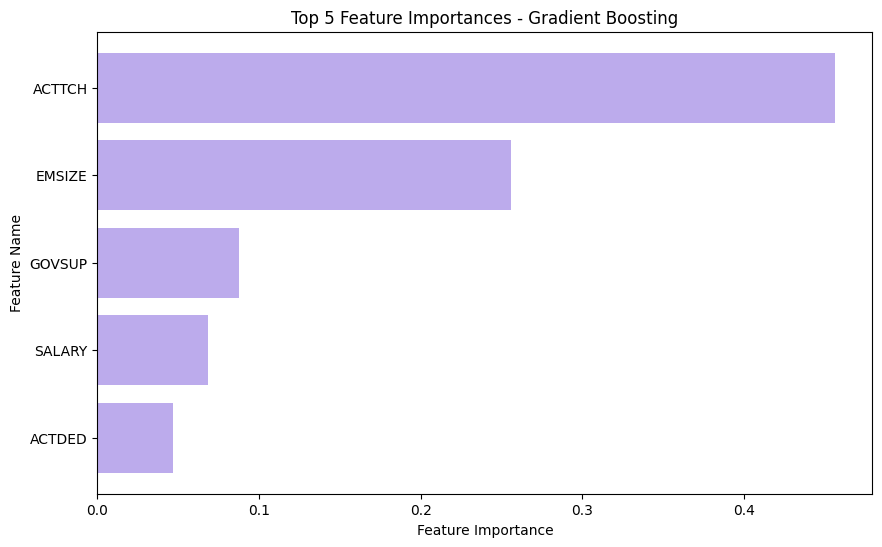

In [50]:
# getting top 5 features, as per Gradient Boosting
df = gb_feature_importances_df.head()

# Sort the DataFrame by Importance in descending order
df = df.sort_values(by='Importance', ascending=True)

# Plotting the horizontal bar chart
plt.figure(figsize=(10, 6))
plt.barh(df['Variable Name'], df['Importance'], color='#bcabec')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Top 5 Feature Importances - Gradient Boosting') 
plt.show()


### Limitations

- hardware limitations. Could not use Support Vector Machine, and could not perform hyperparameter tuning, due to hardware constraints.
- No demographic data.
- These results are most likely only useful for future iterations of this survey. May not be generalizable to other similar surveys.

## Hyperparameter Tuning

In [51]:
# param_grid = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4]
# }


In [52]:
# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
# grid_search.fit(X_train, y_train)

In [53]:
# best_params = grid_search.best_params_
# print("Best Hyperparameters:", best_params)

In [54]:
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test)
# accuracy = accuracy_score(y_test, y_pred)
# print("Test Accuracy:", accuracy)

In [55]:
# random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=5, scoring='accuracy', random_state=42)
# random_search.fit(X_train, y_train)